In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from time import time
from k_medoids import KMedoids
from cluster_statistics import ClusterStatistics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from data_preparation import DataPreparation
from dissimilarity_matrix import DissimilarityMatrix


In [2]:
# get path to multi resolution hic data
path_wt = '/home/elinfi/coolers/HiC_wt_001.mcool'
path_cancer = '/home/elinfi/coolers/HiC_cancer_001.mcool'

resolution = 32000
region = 'chr4:5M-7M' # region of genome

# create objects of class
wt = DataPreparation(path_wt, resolution, region)
cancer = DataPreparation(path_cancer, resolution, region)

# create balanced matrices (not necessary for the following steps)
balance = True
wt.create_matrix(balance=balance)
cancer.create_matrix(balance=balance)

# divide matrices
#diff_mat = wt.divide(cancer, replace_zero_zero=False)
diff_mat = cancer.subtract(wt)
print(wt.matrix.shape)

(63, 63)


[Text(0.5, 1.0, 'Cancer')]

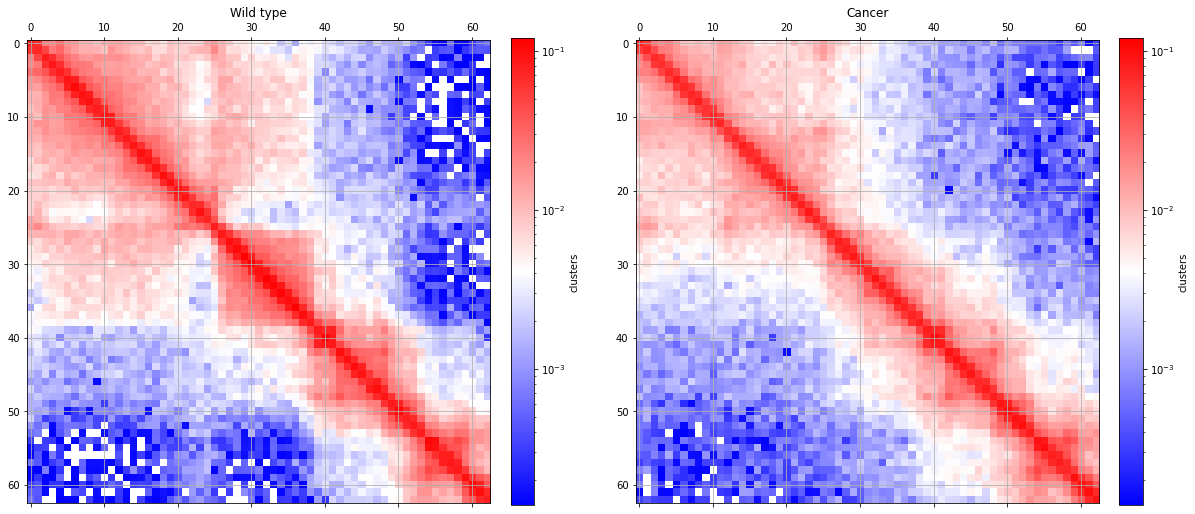

In [3]:
f, axs = plt.subplots(figsize=(20, 20),
                      nrows=1,
                      ncols=2,
                      sharex=True, sharey=False)

norm = mpl.colors.LogNorm()
#norm = None

ax = axs[0]
im = ax.matshow(wt.matrix,
                norm=norm,
                cmap='bwr',
                alpha=1)
plt.colorbar(im, fraction=0.046, pad=0.04, label='clusters', ax=ax)
ax.grid(b=True)
ax.set(title='Wild type')

ax = axs[1]
im = ax.matshow(cancer.matrix,
                norm=norm,
                cmap='bwr',
                alpha=1)
plt.colorbar(im, fraction=0.046, pad=0.04, label='clusters', ax=ax)
ax.grid(b=True)
ax.set(title='Cancer')

In [4]:
### create distance matrix
dissimilarity = DissimilarityMatrix(diff_mat, scaler=None)

# interactions difference
start = time()
interactions_dist = dissimilarity.scipy_dist(metric='interactions_dist', col1=0, col2=3)
end = time()
print(f'Time interactions_dist: {end - start}')

# diagonal distance
start = time()
diagonal_dist = dissimilarity.scipy_dist(metric='diagonal_dist', col1=0, col2=2)
end = time()
print(f'Time diagonal_dist: {end - start}')
"""
# manhattan distance
start = time()
manhattan_dist = dissimilarity.scipy_dist(metric='manhattan')
end = time()
print(f'Time manhattan_dist: {end - start}')
"""
# manhattan distance
start = time()
euclidean_dist = dissimilarity.scipy_dist(metric='minkowski', col1=0, col2=2, p=1)/(2*dissimilarity.n)
end = time()
print(f'Time manhattan_dist: {end - start}')

# manhattan distance
start = time()
euclidean_dist = dissimilarity.scipy_dist(metric='diag_3d_dist', col1=0, col2=3)
end = time()
print(f'Time manhattan_dist: {end - start}')

Time interactions_dist: 2.2489802837371826
Time diagonal_dist: 4.646314382553101
Time manhattan_dist: 0.05488276481628418
Time manhattan_dist: 15.22527003288269


In [5]:
# calculate weighted distance matrix
w1 = 0
w2 = 0
w3 = 0
w4 = 1

#dist_mat = w1*interactions_dist + w2*diagonal_dist + w3*manhattan_dist + w4*euclidean_dist
dist_mat = w1*interactions_dist + w4*euclidean_dist + w2*diagonal_dist

In [6]:
### calculate kmedoids clusters
medoids = 5
random_state = 19

n = dissimilarity.n
triu_nan_idx = dissimilarity.triu_nan_idx

# find clusters using k-medoids
kmedoids = KMedoids(dist_mat)
cluster_result = kmedoids.clusters(medoids=medoids, random_state=random_state)
labels_mat = kmedoids.labels4plotting_nan(n, triu_nan_idx)


In [7]:
# create discrete colormap
cmap = plt.cm.cool
bounds = np.linspace(0, medoids, medoids+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

[Text(0.5, 1.0, 'Weighted dissimilarity')]

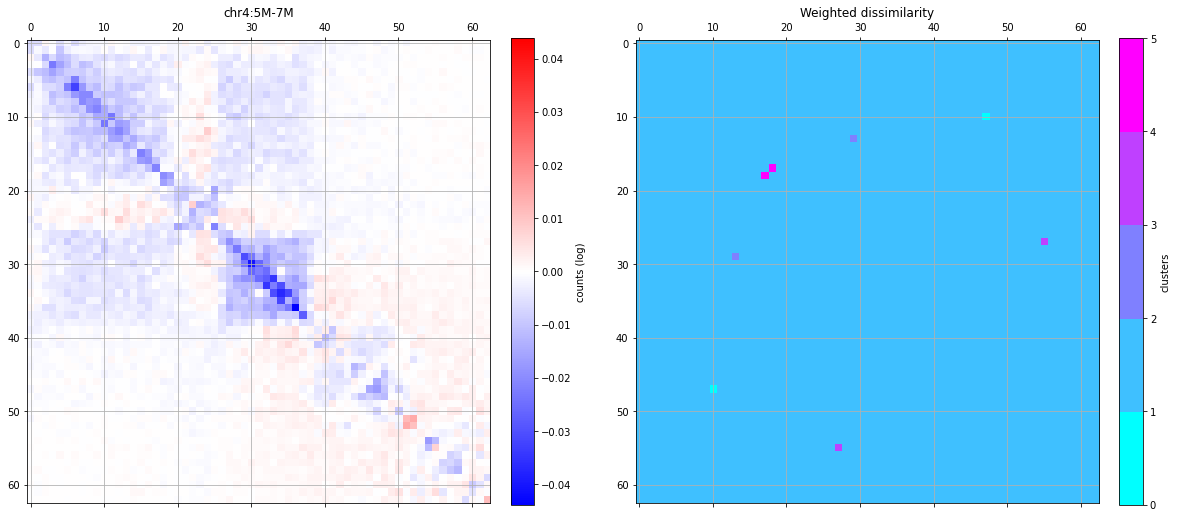

In [8]:
f, axs = plt.subplots(figsize=(20, 20),
                      nrows=1,
                      ncols=2,
                      sharex=True, sharey=False)

ax = axs[0]
vmax = np.nanmax(abs(diff_mat))
im = ax.matshow(diff_mat,
                vmax=vmax,
                vmin=-vmax,
                cmap='bwr')
plt.colorbar(im, fraction=0.046, pad=0.04, label='counts (log)', ax=ax)
ax.grid(b=True)
ax.set(title=region)

ax = axs[1]
im = ax.matshow(labels_mat,
                norm=norm,
                cmap=cmap,
                alpha=1)
plt.colorbar(im, fraction=0.046, pad=0.04, label='clusters', ax=ax)
ax.grid(b=True)
ax.set(title='Weighted dissimilarity')

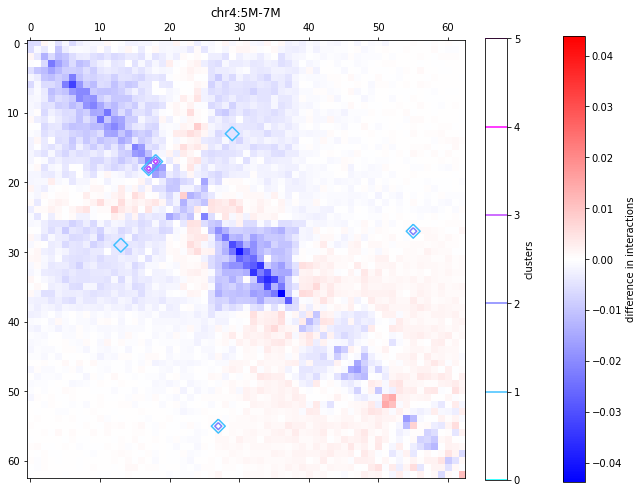

In [9]:
f, axs = plt.subplots(figsize=(10, 10),
                      nrows=1,
                      ncols=1,
                      sharex=True, sharey=False)

ax = axs
vmax = np.nanmax(abs(diff_mat))
im = ax.matshow(diff_mat,
                #norm=mpl.colors.LogNorm(),
                cmap='bwr',
                vmin=-vmax,
                vmax=vmax)
plt.colorbar(im, fraction=0.04, pad=0.1, label='difference in interactions', ax=ax)

im = ax.contour(labels_mat,
                norm=norm,
                cmap='cool',
                levels=bounds,
                alpha=1)
plt.colorbar(im, fraction=0.046, pad=0.04, label='clusters', ax=ax)
ax.set(title=region)
ax.set_facecolor('xkcd:green')

In [10]:
stats = ClusterStatistics(medoids, cluster_result.labels, dissimilarity.X)
mean_list = stats.cluster_mean('diagonal_dist')
print(mean_list)

[37.         20.66699801 16.         28.          1.        ]
